### Try and use changes in spectrogram 2d array to predict strums and note changes

In [253]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pretty_midi
import librosa

In [254]:
input_cleaned_filename = "mp3_input/bass_FLLS_clean.mp3"

seconds_start = 0
seconds_end = 10

x, sr = librosa.load(input_cleaned_filename)
x_custom_time = x[seconds_start * sr :seconds_end*sr]

In [255]:
strums = [0.491, 1.404, 2.282, 2.620, 2.876, 3.799, 4.618, 4.888, 5.275, 6.184, 7.084, 7.426, 7.715]
strums_light = [2.0165, 3.511, 4.420, 5.896, 6.767]

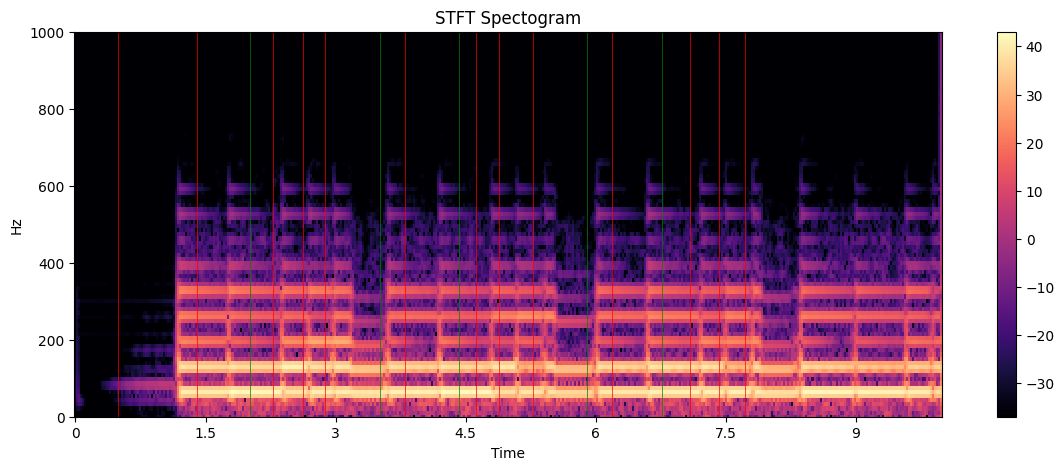

In [256]:
# x , sr = librosa.load(audio_path, sr = 22050) #loading the 11th file just for trial
X = librosa.stft(x_custom_time)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.ylim(0, 1000)
plt.title('STFT Spectogram')
plt.colorbar()

for s in strums:
    plt.axvline(x=s, color='r', linewidth=0.5, linestyle="-")
for s in strums_light:
    plt.axvline(x=s, color='g', linewidth=0.5, linestyle="-")

In [257]:
Xdb[20]

array([-36.25201   , -28.497255  , -33.093964  , -34.700397  ,
       -35.037235  , -35.288166  , -35.322865  , -35.38265   ,
       -35.44436   , -35.53746   , -35.580276  , -35.656742  ,
       -35.773834  , -35.7462    , -35.75255   , -35.818924  ,
       -35.687057  , -35.52794   , -35.55624   , -35.61762   ,
       -35.41092   , -34.952255  , -34.545094  , -34.606804  ,
       -34.777443  , -33.865013  , -33.56886   , -34.96798   ,
       -36.32257   , -36.028435  , -34.59029   , -33.50538   ,
       -34.17485   , -34.077656  , -31.201117  , -29.869312  ,
       -30.954136  , -33.64946   , -32.988945  , -31.263617  ,
       -31.869518  , -33.137314  , -34.201126  , -30.716707  ,
       -28.535511  , -29.268263  , -31.406384  , -32.10803   ,
       -26.2484    , -17.71383   ,   4.228181  ,  17.264517  ,
        13.256453  ,   0.33663726,  -2.4147367 ,  -2.3729215 ,
        -2.0933797 ,  -7.615056  ,  -5.3737874 ,  -1.0008647 ,
        -8.152403  ,  -2.2121775 ,  -3.8491952 ,  -3.95

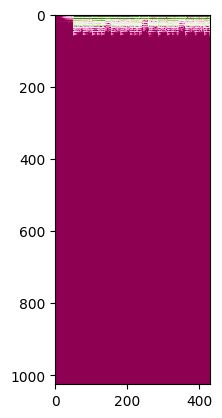

In [258]:
plt.imshow(Xdb, cmap='PiYG', interpolation='nearest')
plt.show()

In [259]:
Xdb_df = pd.DataFrame(Xdb)

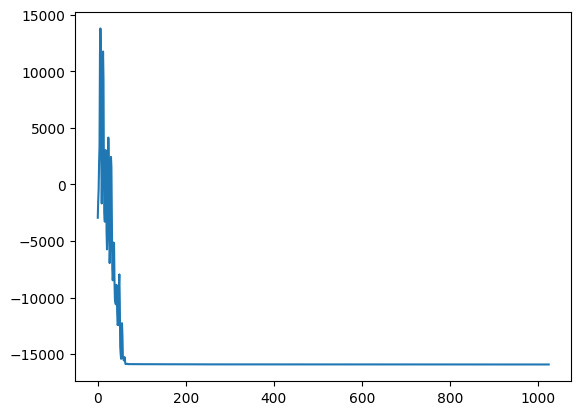

In [260]:
#use this to show how much of the lower rows are empty
row_sums = Xdb_df.sum(axis=1)
plt.plot(row_sums)

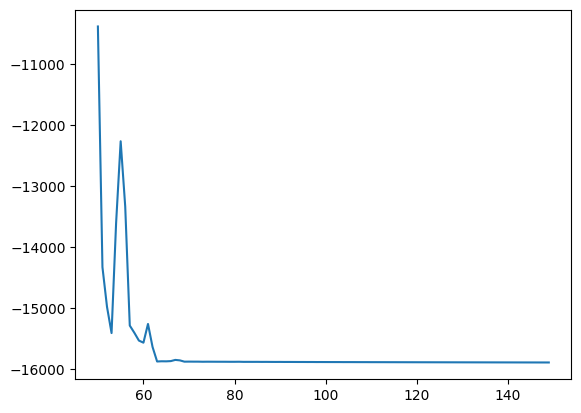

In [261]:
#look into where it plateaus 
plt.plot(row_sums[50:150])

In [262]:
#cutoff at index 70
[row_index for row_index in range(len(row_sums)) if row_sums[row_index] < -17000]


[]

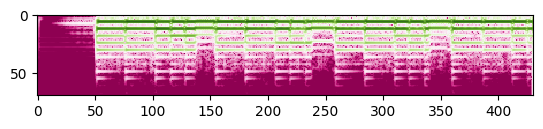

In [263]:
Xdb_condensed = Xdb[:70]

plt.imshow(Xdb_condensed, cmap='PiYG', interpolation='nearest')
plt.show()

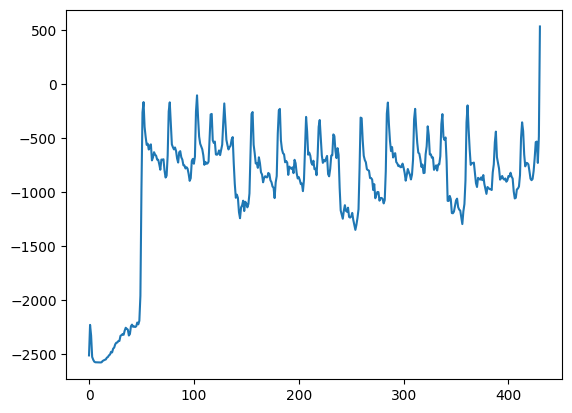

In [264]:
#column sums
col_sums = Xdb_condensed.sum(axis=0)
plt.plot(col_sums)

[0.02105093188583851, 0.11187832057476044, 0.08014187216758728, 0.016460465267300606, 0.008217343129217625, 0.002523494651541114, 0.0006296198698692024, 0.00048120669089257717, 0.00026806839741766453, 3.612380533013493e-05, 0.0, 7.937834016047418e-05, 0.0005943580181337893, 0.00450748298317194, 0.0063116359524428844, 0.007955464534461498, 0.008878462947905064, 0.014278541319072247, 0.01625955104827881, 0.021138302981853485, 0.02358194813132286, 0.03173033520579338, 0.029848841950297356, 0.04105913266539574, 0.04432038217782974, 0.0540647991001606, 0.05878165736794472, 0.05940501019358635, 0.06398199498653412, 0.06419466435909271, 0.07925257086753845, 0.08145181089639664, 0.08444609493017197, 0.08241359889507294, 0.094556525349617, 0.10330616682767868, 0.100257508456707, 0.0977691188454628, 0.08028582483530045, 0.08468728512525558, 0.10801926255226135, 0.11261944472789764, 0.10610955953598022, 0.10759863257408142, 0.10561127215623856, 0.10751470923423767, 0.11888798326253891, 0.11350138

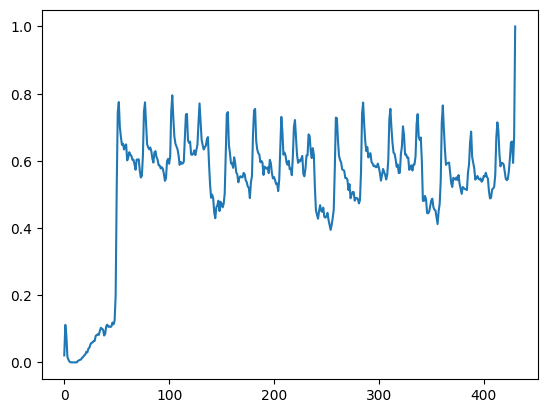

In [265]:
#standardize so that the same prominance can be used between songs 
col_sums_std = (col_sums - col_sums.min()) / (col_sums.max() - col_sums.min())
print(col_sums_std.tolist())
plt.plot(col_sums_std)

In [266]:
peaks_all, _ = find_peaks(col_sums_std, prominence=0.05)
peaks_strong, _ = find_peaks(col_sums_std, prominence=0.1)

peaks_weak = list(set(peaks_all) - set(peaks_strong))

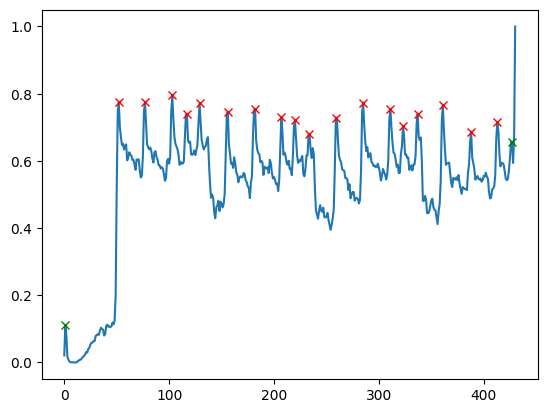

In [267]:
plt.plot(col_sums_std)
plt.plot(peaks_strong, col_sums_std[peaks_strong], "x", color = 'r')
plt.plot(peaks_weak, col_sums_std[peaks_weak], "x", color = 'g')

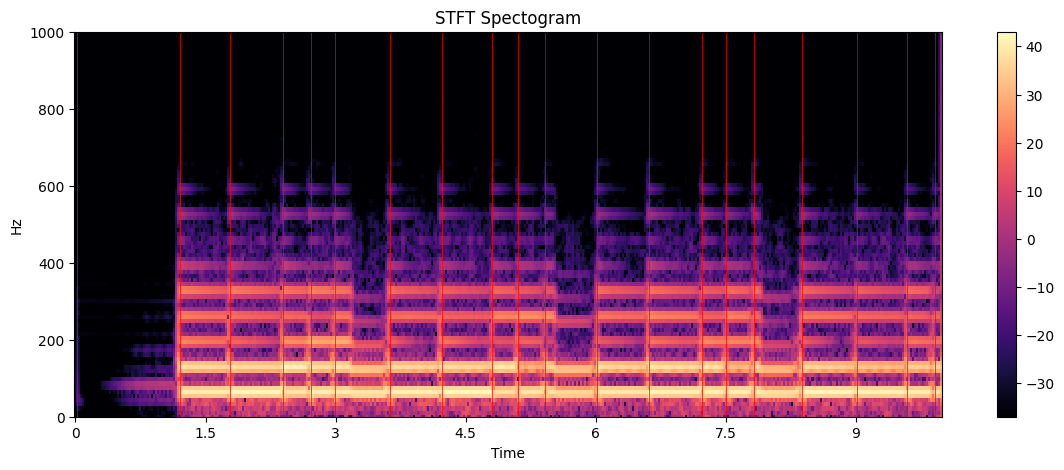

In [268]:
#turn indexes into times 
strums_strong_pred = librosa.frames_to_time(peaks_strong, sr=sr, hop_length=512)
strums_weak_pred = librosa.frames_to_time(peaks_weak, sr=sr, hop_length=512)

# x , sr = librosa.load(audio_path, sr = 22050) #loading the 11th file just for trial
X = librosa.stft(x_custom_time)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.ylim(0, 1000)
plt.title('STFT Spectogram')
plt.colorbar()

for s in strums_strong_pred:
    plt.axvline(x=s, color='r', linewidth=0.5, linestyle="-")
for s in strums_weak_pred:
    plt.axvline(x=s, color='g', linewidth=0.5, linestyle="-")

In [269]:
#turn into 3d array 
#array of strums
#each strum represents freq vs time

Xdb_strums = np.split(Xdb, peaks_strong, axis = 1)

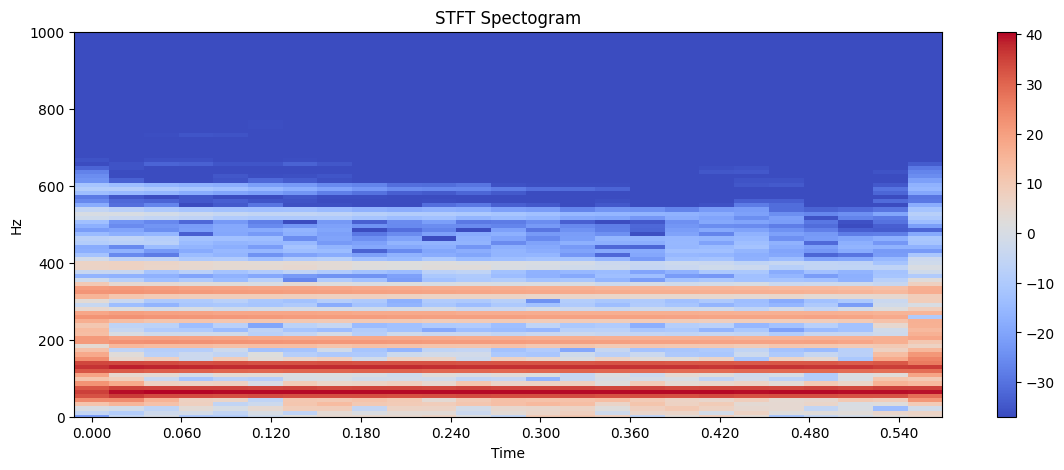

In [270]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb_strums[1], sr=sr, x_axis='time', y_axis='hz')
plt.ylim(0, 1000)
plt.title('STFT Spectogram')
plt.colorbar()

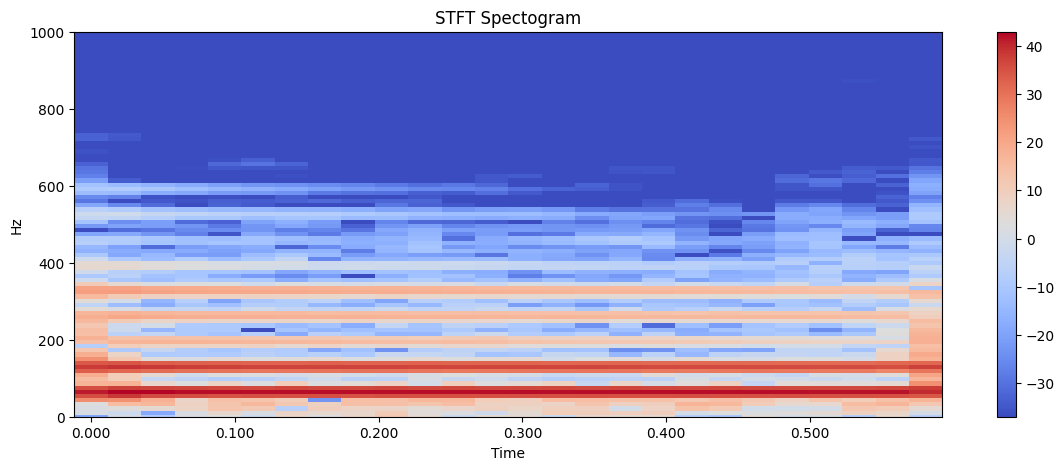

In [271]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb_strums[2], sr=sr, x_axis='time', y_axis='hz')
plt.ylim(0, 1000)
plt.title('STFT Spectogram')
plt.colorbar()

In [272]:
### Finding n most active frequency bands 
top_n_freq = 20

first_strum = Xdb_strums[1]

first_strum_row_sums = first_strum.sum(axis=1)
first_strum_row_sums

first_strum_row_sums_ordered_tup = sorted(list(enumerate(first_strum_row_sums)), key=lambda tup : tup[1], reverse=True)
first_strum_freq_index_orderd = [tup[0] for tup in first_strum_row_sums_ordered_tup]
first_strum_top_n_freq = first_strum_freq_index_orderd[:top_n_freq]
first_strum_top_n_freq

[6, 12, 7, 5, 13, 11, 18, 24, 30, 19, 25, 31, 17, 23, 4, 8, 3, 29, 14, 2]

In [273]:
def top_n_active_freq(Xdb_strum, top_n_freq):
    strum_row_sums = Xdb_strum.sum(axis=1)

    strum_row_sums_ordered_tup = sorted(list(enumerate(strum_row_sums)), key=lambda tup : tup[1], reverse=True)
    strum_freq_index_orderd = [tup[0] for tup in strum_row_sums_ordered_tup]
    strum_top_n_freq = strum_freq_index_orderd[:top_n_freq]
    return (strum_top_n_freq)

top_n_active_freq(Xdb_strums[1], 20)

[6, 12, 7, 5, 13, 11, 18, 24, 30, 19, 25, 31, 17, 23, 4, 8, 3, 29, 14, 2]

In [274]:
top_n_active_freq(Xdb_strums[2], 20)

[6, 12, 7, 5, 13, 11, 30, 24, 31, 25, 18, 4, 3, 19, 23, 29, 2, 8, 14, 17]

In [275]:
strum_1_top_n_freq = top_n_active_freq(Xdb_strums[1], 20)
strum_2_top_n_freq = top_n_active_freq(Xdb_strums[2], 20)

def n_matching_top_bands(strum_a_top_freqs, strum_b_top_freqs):
    intersecting_top_freq = set(strum_a_top_freqs).intersection(set(strum_b_top_freqs))
    return(len(intersecting_top_freq))

def n_matching_top_bands_by_strum(Xdb_strums_split, strum_a_index, strum_b_index, top_n_freq = 20):
    strum_a_top_freqs = top_n_active_freq(Xdb_strums_split[strum_a_index], top_n_freq)
    strum_b_top_freqs = top_n_active_freq(Xdb_strums_split[strum_b_index], top_n_freq)
    n_intersecting_freqs = n_matching_top_bands(strum_a_top_freqs, strum_b_top_freqs)
    return(n_intersecting_freqs)

# intersecting_top_freq = set(strum_1_top_n_freq).intersection(set(strum_2_top_n_freq))
# print(intersecting_top_freq)
# print(len(intersecting_top_freq))
print(n_matching_top_bands(strum_1_top_n_freq, strum_2_top_n_freq))
print(n_matching_top_bands_by_strum(Xdb_strums, 1, 2))

20
20


In [276]:
top_n_active_freq(Xdb_strums[5], 20)

[6, 5, 12, 11, 7, 13, 18, 17, 10, 4, 8, 3, 14, 23, 24, 19, 2, 16, 9, 15]

In [277]:
print(n_matching_top_bands_by_strum(Xdb_strums, 1, 5))

16


In [278]:
print(n_matching_top_bands_by_strum(Xdb_strums, 5, 6))

16


In [279]:
for i in range(len(Xdb_strums)-1):
    print(f"Matching Between strum {i} and {i+1}: {n_matching_top_bands_by_strum(Xdb_strums, i, i+1, top_n_freq=20)}")

Matching Between strum 0 and 1: 14
Matching Between strum 1 and 2: 20
Matching Between strum 2 and 3: 19
Matching Between strum 3 and 4: 19
Matching Between strum 4 and 5: 16
Matching Between strum 5 and 6: 16
Matching Between strum 6 and 7: 18
Matching Between strum 7 and 8: 18
Matching Between strum 8 and 9: 20
Matching Between strum 9 and 10: 14
Matching Between strum 10 and 11: 14
Matching Between strum 11 and 12: 19
Matching Between strum 12 and 13: 18
Matching Between strum 13 and 14: 19
Matching Between strum 14 and 15: 15
Matching Between strum 15 and 16: 15
Matching Between strum 16 and 17: 18
Matching Between strum 17 and 18: 19


### Looking for what appears in one spectrogram that doesn't in another

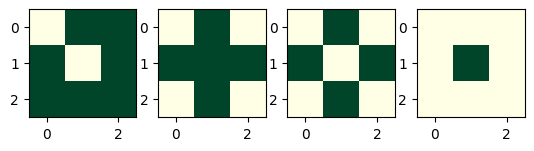

In [280]:
### binary arrays - db>0 -> 1, db<=0 -> 0

arr_a = np.array([[0,1,1],
                  [1,0,1],
                  [1,1,1]])

arr_b = np.array([[0,1,0],
                  [1,1,1],
                  [0,1,0]])

#perform AND so that only positives in A which appear in b will be masked off 
arr_c = np.bitwise_and(arr_a, arr_b)

arr_d = arr_b - arr_c

figure, axis = plt.subplots(1, 4)


axis[0].imshow(arr_a, cmap='YlGn', interpolation='nearest')

axis[1].imshow(arr_b, cmap='YlGn', interpolation='nearest')

axis[2].imshow(arr_c, cmap='YlGn', interpolation='nearest')

axis[3].imshow(arr_d, cmap='YlGn', interpolation='nearest')

plt.show()

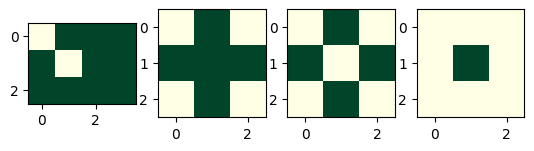

In [281]:
### difference in sizes - need to be made the same 

arr_a = np.array([[0,1,1,1],
                  [1,0,1,1],
                  [1,1,1,1]])

arr_b = np.array([[0,1,0],
                  [1,1,1],
                  [0,1,0]])

#find the smallest size
#theyll both have the same number of rows but will keep this in case
# Get the number of rows and columns for each array
rowsa, colsa = arr_a.shape
rowsb, colsb = arr_b.shape
# Determine the minimum number of rows and columns
min_rows = min(rowsa, rowsb)
min_cols = min(colsa, colsb)

resized_arr_a = arr_a[:min_rows, :min_cols]
resized_arr_b = arr_b[:min_rows, :min_cols]

#perform AND so that only positives in A which appear in b will be masked off 
arr_c = np.bitwise_and(resized_arr_a, resized_arr_b)

arr_d = resized_arr_b - arr_c

figure, axis = plt.subplots(1, 4)


axis[0].imshow(arr_a, cmap='YlGn', interpolation='nearest')

axis[1].imshow(arr_b, cmap='YlGn', interpolation='nearest')

axis[2].imshow(arr_c, cmap='YlGn', interpolation='nearest')

axis[3].imshow(arr_d, cmap='YlGn', interpolation='nearest')

plt.show()

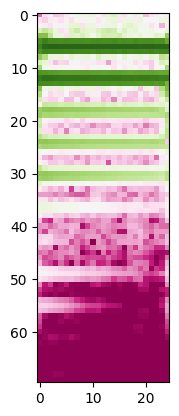

In [282]:
plt.imshow(first_strum[:70], cmap='PiYG', interpolation='nearest')
plt.show()

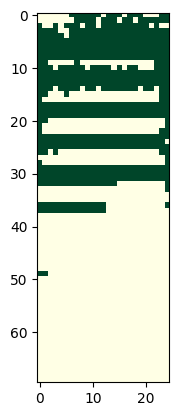

In [283]:
#change this to determine what is 0 and 1
#larger calue means only the more dominant decibels will be 1s - might get false positives for differences
# smaller value probably false negatives 
bool_cutoff = 0

plt.imshow((first_strum[:70]>bool_cutoff).astype(int), cmap='YlGn', interpolation='nearest')
plt.show()

In [284]:
# strum_a_bool = (first_strum[:70]>bool_cutoff).astype(int)
# strum_b_bool = (Xdb_strums[2][:70]>bool_cutoff).astype(int)

# strum_a_b_and = np.bitwise_and(strum_a_bool, strum_b_bool)

# difference_bool = strum_b_bool - strum_a_b_and

# figure, axis = plt.subplots(1, 4)

# axis[0].imshow(strum_a_bool, cmap='YlGn', interpolation='nearest')

# axis[1].imshow(strum_b_bool, cmap='YlGn', interpolation='nearest')

# axis[2].imshow(strum_a_b_and, cmap='YlGn', interpolation='nearest')

# axis[3].imshow(difference_bool, cmap='YlGn', interpolation='nearest')

# plt.show()

In [285]:
### Method to show differences between strums 
def strum_diff_graph(strum_a, strum_b, bool_cutoff):
    strum_a_bool = (strum_a[:70]>bool_cutoff).astype(int)
    strum_b_bool = (strum_b[:70]>bool_cutoff).astype(int)

    #make the same size to perform bitwise operations
    #find the smallest size
    #theyll both have the same number of rows but will keep this in case
    # Get the number of rows and columns for each array
    rowsa, colsa = strum_a_bool.shape
    rowsb, colsb = strum_b_bool.shape
    # Determine the minimum number of rows and columns
    min_rows = min(rowsa, rowsb)
    min_cols = min(colsa, colsb)

    resized_strum_a_bool = strum_a_bool[:min_rows, :min_cols]
    resized_strum_b_bool = strum_b_bool[:min_rows, :min_cols]

    strum_a_b_and = np.bitwise_and(resized_strum_a_bool, resized_strum_b_bool)

    difference_bool = resized_strum_b_bool - strum_a_b_and

    figure, axis = plt.subplots(1, 4)

    axis[0].imshow(strum_a_bool, cmap='YlGn', interpolation='nearest')

    axis[1].imshow(strum_b_bool, cmap='YlGn', interpolation='nearest')

    axis[2].imshow(strum_a_b_and, cmap='YlGn', interpolation='nearest')

    axis[3].imshow(difference_bool, cmap='YlGn', interpolation='nearest')

    plt.show()

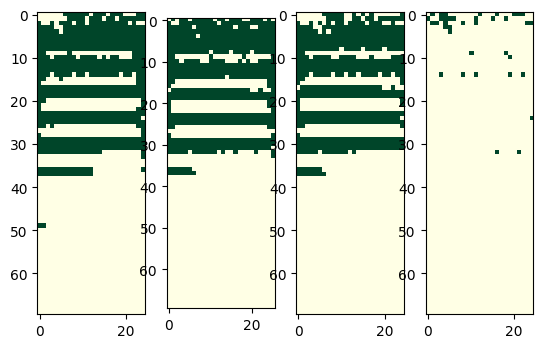

In [286]:
strum_diff_graph(Xdb_strums[1], Xdb_strums[2], 0)

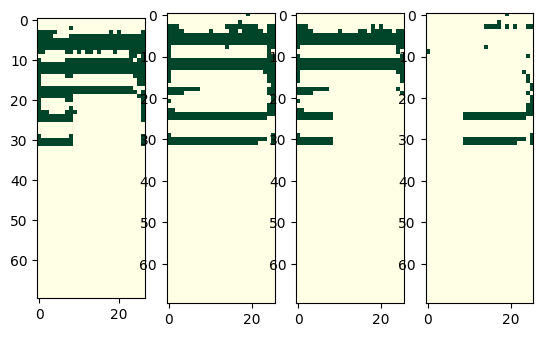

In [287]:
strum_diff_graph(Xdb_strums[5], Xdb_strums[6], 10)

### Quantifying Difference using XOR

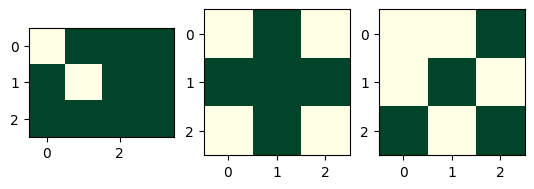

In [288]:
### difference in sizes - need to be made the same 

arr_a = np.array([[0,1,1,1],
                  [1,0,1,1],
                  [1,1,1,1]])

arr_b = np.array([[0,1,0],
                  [1,1,1],
                  [0,1,0]])

#find the smallest size
#theyll both have the same number of rows but will keep this in case
# Get the number of rows and columns for each array
rowsa, colsa = arr_a.shape
rowsb, colsb = arr_b.shape
# Determine the minimum number of rows and columns
min_rows = min(rowsa, rowsb)
min_cols = min(colsa, colsb)

resized_arr_a = arr_a[:min_rows, :min_cols]
resized_arr_b = arr_b[:min_rows, :min_cols]

#perform XOR so that only differences are kept
arr_c = np.bitwise_xor(resized_arr_a, resized_arr_b)

figure, axis = plt.subplots(1, 3)


axis[0].imshow(arr_a, cmap='YlGn', interpolation='nearest')

axis[1].imshow(arr_b, cmap='YlGn', interpolation='nearest')

axis[2].imshow(arr_c, cmap='YlGn', interpolation='nearest')

plt.show()

In [289]:
### Method to show differences between strums 
def strum_diff_graph_XOR(strum_a, strum_b, bool_cutoff):
    strum_a_bool = (strum_a[:70]>bool_cutoff).astype(int)
    strum_b_bool = (strum_b[:70]>bool_cutoff).astype(int)

    #make the same size to perform bitwise operations
    #find the smallest size
    #theyll both have the same number of rows but will keep this in case
    # Get the number of rows and columns for each array
    rowsa, colsa = strum_a_bool.shape
    rowsb, colsb = strum_b_bool.shape
    # Determine the minimum number of rows and columns
    min_rows = min(rowsa, rowsb)
    min_cols = min(colsa, colsb)

    resized_strum_a_bool = strum_a_bool[:min_rows, :min_cols]
    resized_strum_b_bool = strum_b_bool[:min_rows, :min_cols]

    #XOR to get the difference
    difference_bool = np.bitwise_xor(resized_strum_a_bool, resized_strum_b_bool)

    figure, axis = plt.subplots(1, 3)

    axis[0].imshow(strum_a_bool, cmap='YlGn', interpolation='nearest')

    axis[1].imshow(strum_b_bool, cmap='YlGn', interpolation='nearest')

    axis[2].imshow(difference_bool, cmap='YlGn', interpolation='nearest')

    plt.show()

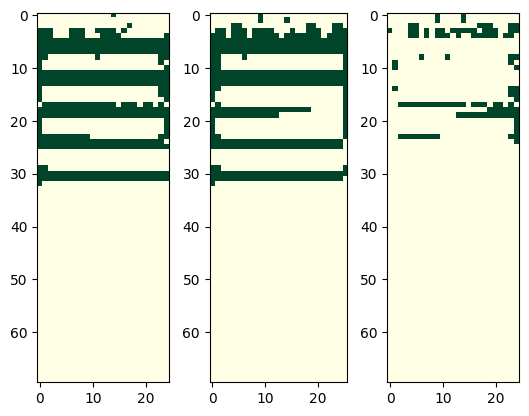

In [290]:
strum_diff_graph_XOR(Xdb_strums[1], Xdb_strums[2], 10)

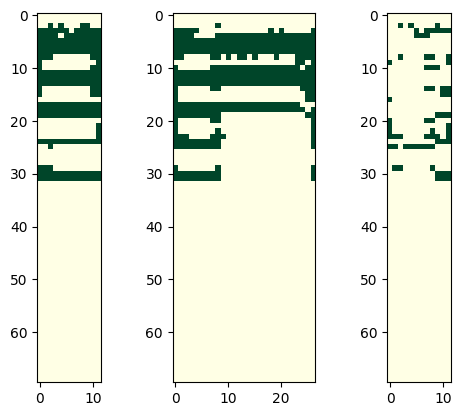

In [291]:
strum_diff_graph_XOR(Xdb_strums[4], Xdb_strums[5], 10)

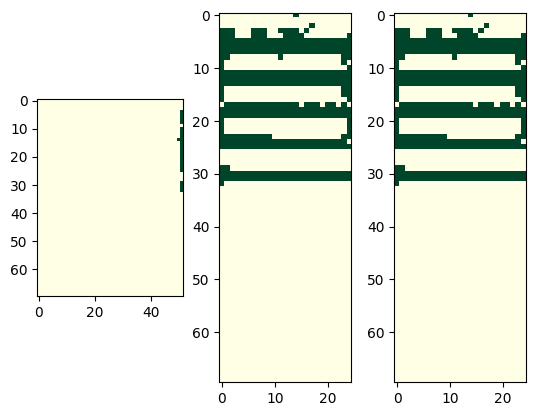

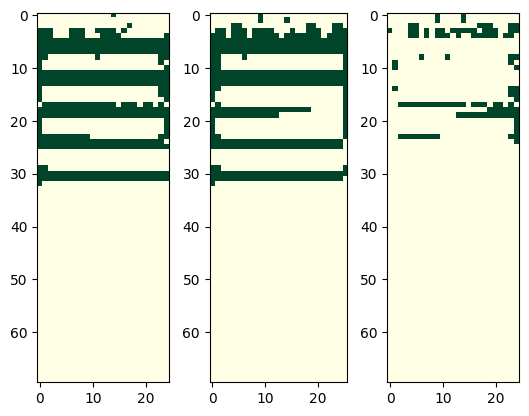

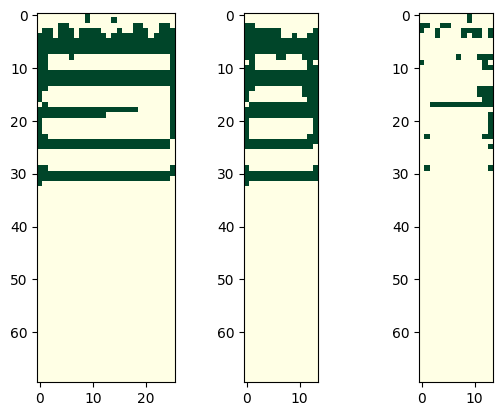

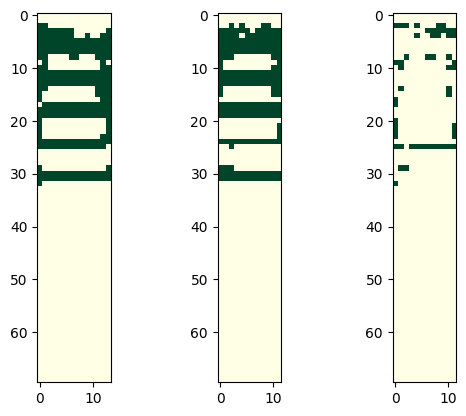

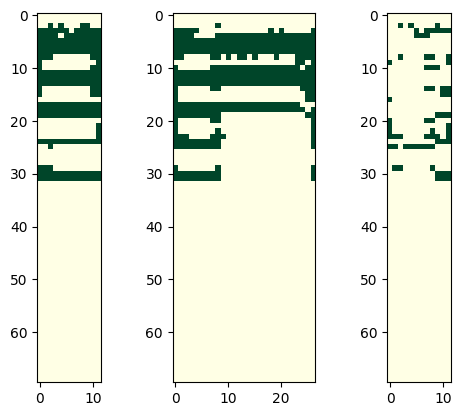

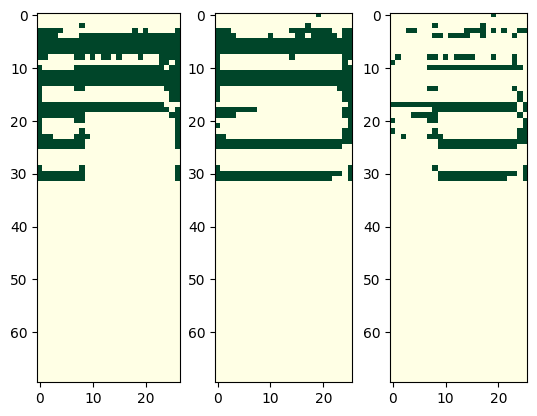

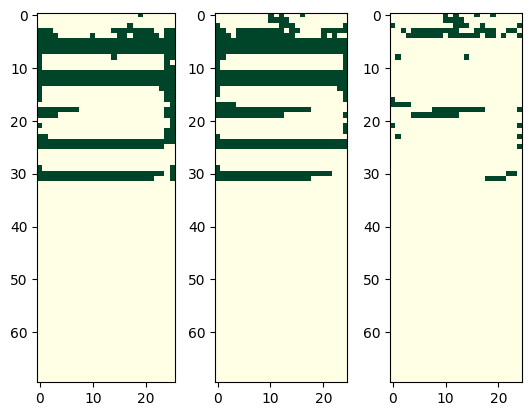

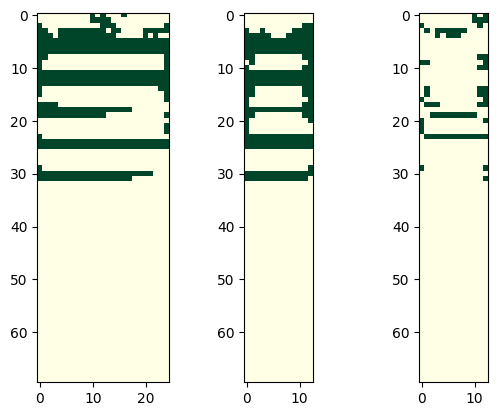

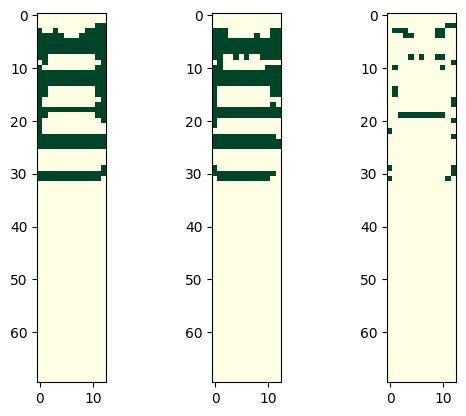

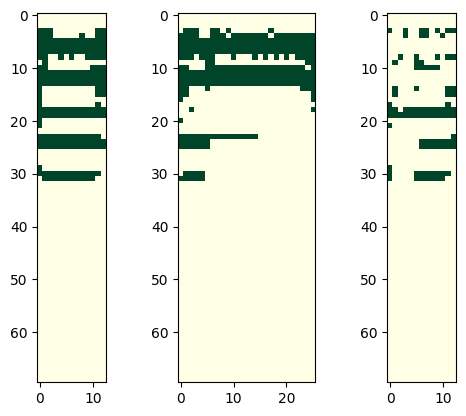

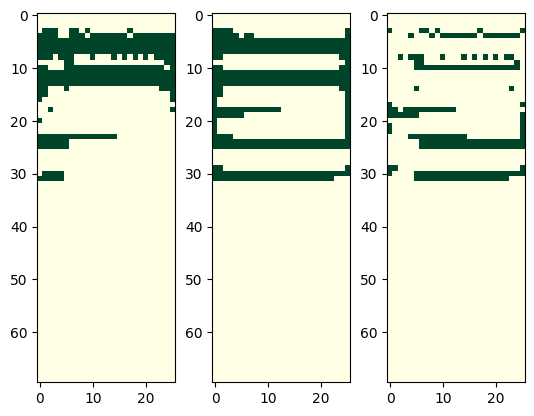

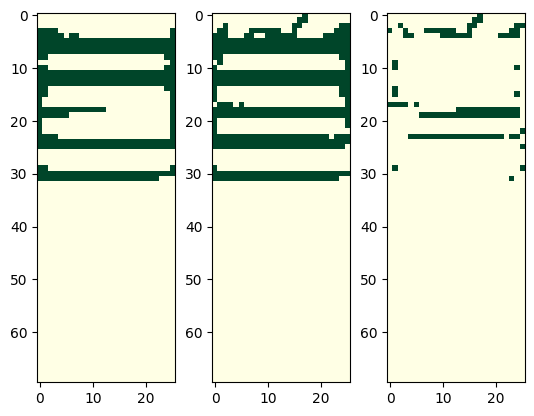

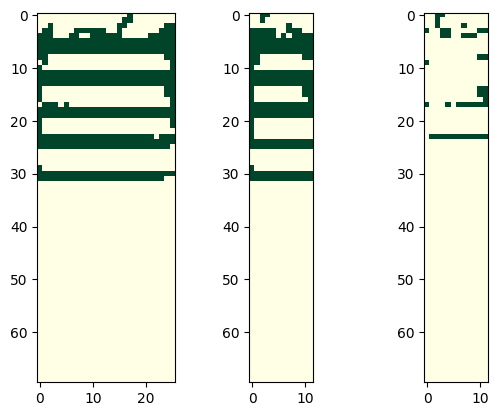

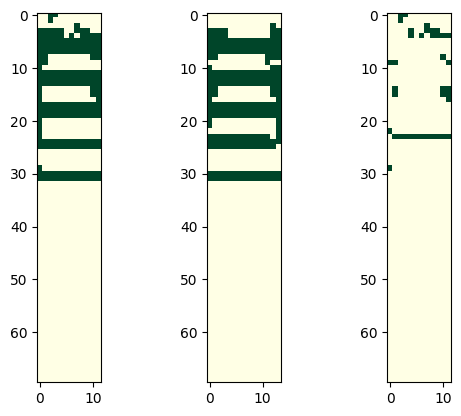

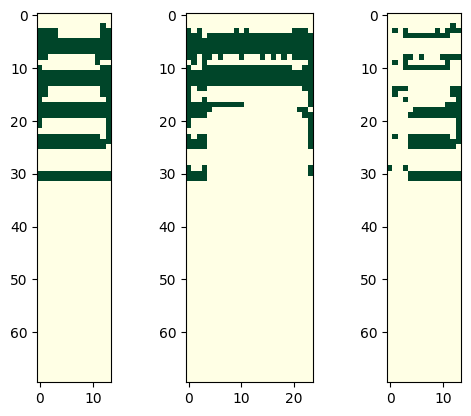

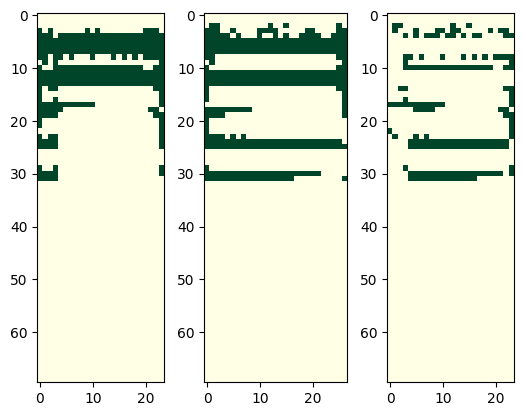

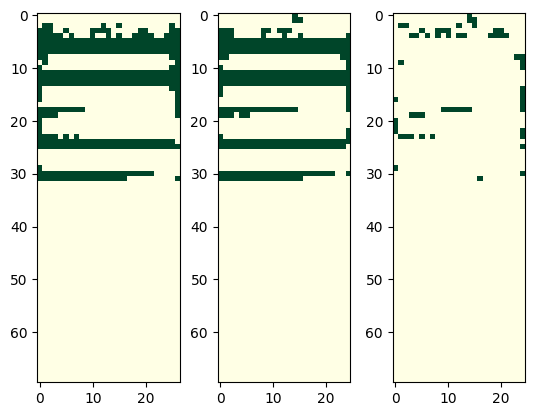

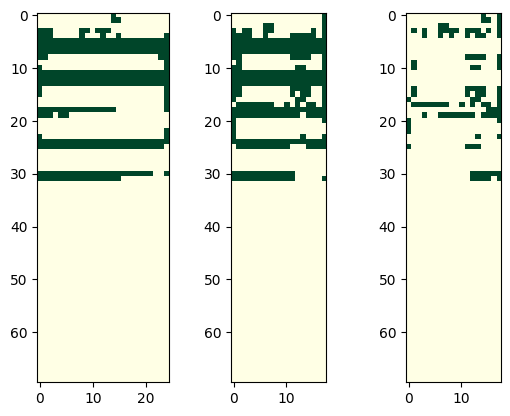

In [292]:
for i in range(len(Xdb_strums)-1):
    strum_diff_graph_XOR(Xdb_strums[i], Xdb_strums[i+1], 10)

### Look at Relative increase to identify bands instead of ansolute value

In [293]:
#NGHYB first note change is between strum 4 and 5
first_strum_df = pd.DataFrame(first_strum[:70])
fifth_strum_df = pd.DataFrame(Xdb_strums[5][:70])

first_strum_df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-21.583061,-5.264432,-0.858624,-10.457734,-8.888274,-2.903687,2.105116,4.691900,4.976254,4.969660,...,7.936076,-6.150976,3.158362,8.097952,3.309390,-11.815845,-5.480649,-1.451552,2.801096,5.160315
1,-5.386515,-9.046264,-2.520660,-1.255117,-5.634282,-0.056652,-6.274826,3.776784,0.782026,3.392880,...,-2.556914,5.478742,5.960057,-1.430947,7.071061,2.051034,2.457740,2.841251,5.627987,6.676889
2,0.461305,-1.481279,-5.851231,3.315575,-0.227409,4.468052,8.734688,8.511069,-4.956913,6.803292,...,2.324154,7.914231,10.051668,7.051402,4.537801,4.295759,-5.319588,0.601093,-14.014688,-1.561137
3,11.532140,15.167595,12.095226,7.716779,-5.789802,-2.842796,11.102029,13.748045,10.205048,9.541381,...,6.279735,11.329664,7.168160,9.128565,3.581347,4.461764,5.925860,0.450077,2.292551,9.522256
4,23.784674,23.667391,15.960809,7.445983,6.003031,-5.943961,10.813398,10.009886,11.509233,9.644693,...,13.039989,9.598525,6.722913,5.225137,8.210361,4.152030,4.685328,9.948148,8.577573,21.652863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,...,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968
66,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,...,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968
67,-36.677502,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,...,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968
68,-36.953968,-36.953968,-36.551239,-35.302010,-35.457287,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,...,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968,-36.953968


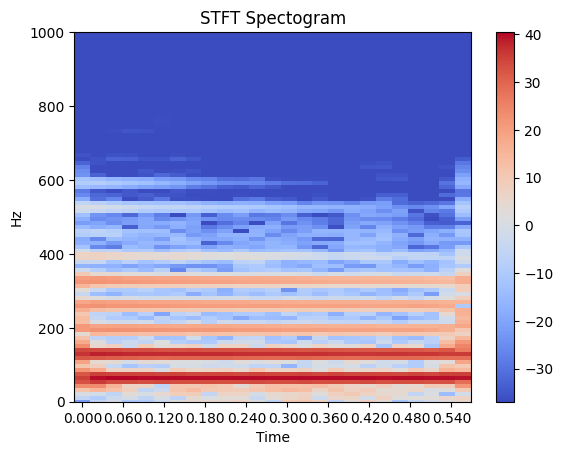

In [294]:
librosa.display.specshow(Xdb_strums[1], sr=sr, x_axis='time', y_axis='hz')
plt.ylim(0, 1000)
plt.title('STFT Spectogram')
plt.colorbar()

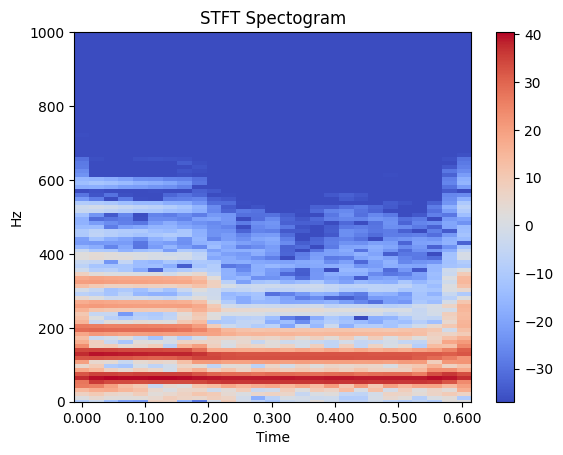

In [295]:
librosa.display.specshow(Xdb_strums[5], sr=sr, x_axis='time', y_axis='hz')
plt.ylim(0, 1000)
plt.title('STFT Spectogram')
plt.colorbar()

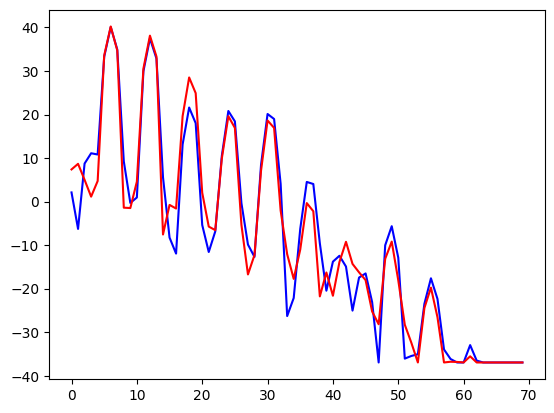

In [296]:
slice_index = 6

#look at the db values of a vertical slice
plt.plot(first_strum_df.iloc[:,slice_index], color = 'b')
plt.plot(fifth_strum_df.iloc[:,slice_index], color = 'r')

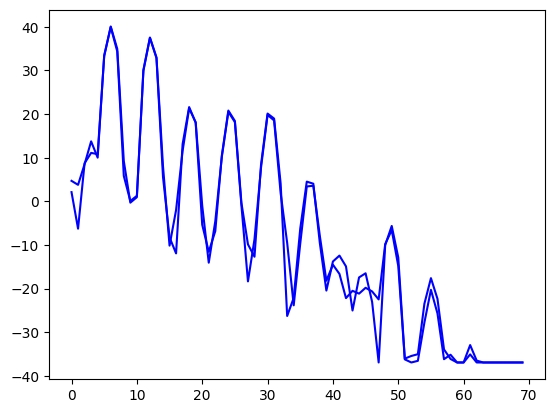

In [297]:
slice_index = 6

# figure, axis = plt.subplots(2, 4)

# axis[0,0].plot(first_strum_df.iloc[:,slice_index], color = 'b')
# axis[0,1].plot(first_strum_df.iloc[:,slice_index+1], color = 'b')
plt.plot(first_strum_df.iloc[:,slice_index], color = 'b')
plt.plot(first_strum_df.iloc[:,slice_index+1], color = 'b')


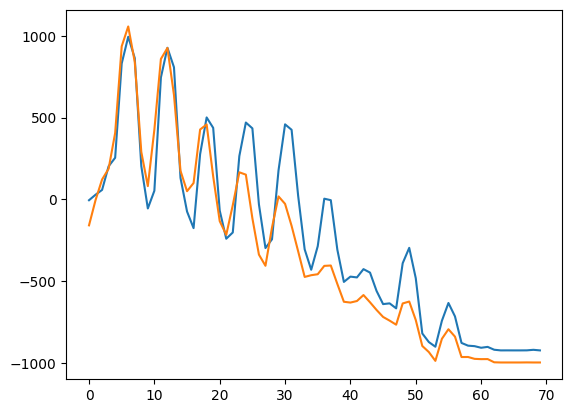

In [298]:
### take sum of each row
first_strum_row_sums = first_strum[:70].sum(axis=1)
fifth_strum_row_sums = Xdb_strums[5][:70].sum(axis=1)
plt.plot(first_strum_row_sums)
plt.plot(fifth_strum_row_sums)

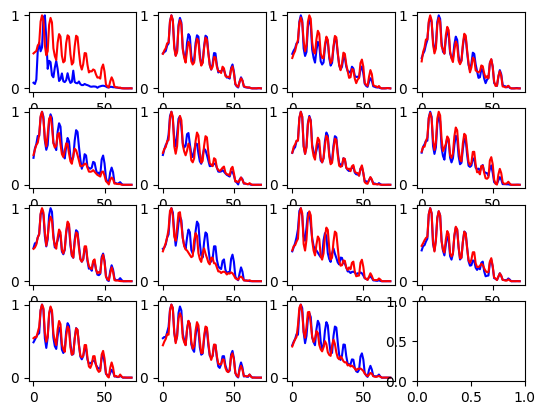

In [299]:
#visualise between strums
#4x4 

cols = 4
rows = 4
figure, axis = plt.subplots(rows, cols)

for i in range(min(len(Xdb_strums), rows * cols) -1):
    r = i//cols
    c = i%cols
    strum_a_sum = Xdb_strums[i][:70].sum(axis=1)
    strum_b_sum = Xdb_strums[i+1][:70].sum(axis=1)

    strum_a_sum_std = (strum_a_sum - strum_a_sum.min()) / (strum_a_sum.max() - strum_a_sum.min())
    strum_b_sum_std = (strum_b_sum - strum_b_sum.min()) / (strum_b_sum.max() - strum_b_sum.min())

    axis[r,c].plot(strum_a_sum_std, color = 'b')
    axis[r,c].plot(strum_b_sum_std, color = 'r')

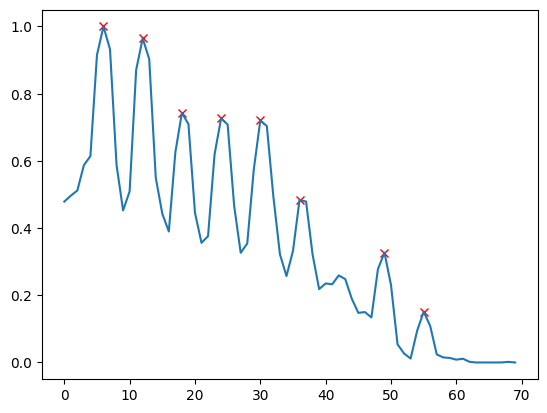

In [300]:
#find peaks 

first_strum_row_sums_std = (first_strum_row_sums - first_strum_row_sums.min()) / (first_strum_row_sums.max() - first_strum_row_sums.min())

first_strum_freq_peaks, _ = find_peaks(first_strum_row_sums_std, prominence=0.05)

plt.plot(first_strum_freq_peaks, first_strum_row_sums_std[first_strum_freq_peaks], "x", color = 'r')
plt.plot(first_strum_row_sums_std)

In [301]:
prominance = 0.5

for i in range(len(Xdb_strums)):
    strum_a_sum = Xdb_strums[i][:70].sum(axis=1)
    # strum_b_sum = Xdb_strums[i+1][:70].sum(axis=1)

    strum_a_sum_std = (strum_a_sum - strum_a_sum.min()) / (strum_a_sum.max() - strum_a_sum.min())
    # strum_b_sum_std = (strum_b_sum - strum_b_sum.min()) / (strum_b_sum.max() - strum_b_sum.min())

    # axis[r,c].plot(strum_a_sum_std, color = 'b')
    # axis[r,c].plot(strum_b_sum_std, color = 'r')

    strum_freq_peaks, _ = find_peaks(strum_a_sum_std, prominence=0.05)
    print(strum_freq_peaks)

[ 4  8 11 16 20 24 28]
[ 6 12 18 24 30 36 49 55]
[ 6 12 18 24 30 36 42 49 55]
[ 6 12 18 24 30 36 42 49 55]
[ 6 12 18 24 30 36 42 49 55]
[ 6 12 18 23 29 49 55]
[ 6 12 18 24 30 36 43 49 55]
[ 6 12 18 24 30 36 43 49 55]
[ 6 12 18 24 30 37 43 49 55]
[ 6 12 18 24 30 36 43 49 55]
[ 6 12 23 29 34]
[ 6 12 18 24 30 36 43 49 55]
[ 6 12 18 24 30 37 49 55]
[ 6 12 18 24 30 36 43 49 55]
[ 6 12 18 24 30 36 42 49 55]
[ 6 12 17 23 29]
[ 6 12 18 24 30 36 43 49 55]
[ 6 12 18 24 30 37 42 49 55]
[ 6 12 18 24 30 37 43 49 55]
